## PFDA Project - Contact Center Performance Analysis

In [3]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Import Data & Set Index
df = pd.read_excel('pwc_call_centre_data.xlsx')
df.set_index('Date', inplace=True)
df.head()

,Call Id,Agent,Time,Topic,Answered (Y/N),Resolved,Speed of answer in seconds,AvgTalkDuration,Satisfaction rating
Date,,,,,,,,,
2021-01-01,ID0001,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0
2021-01-01,ID0002,Becky,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0
2021-01-01,ID0003,Stewart,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0
2021-01-01,ID0004,Greg,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0
2021-01-01,ID0005,Becky,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0


In [14]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()


## Section 1 - Data Cleaning

To analyse the data efficiently and see if there is a correlation between speed of answer in seconds and AvgTalkDuration they most both be in seconds. Pandas documentation shows how to convert minutes into seconds https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.total_seconds.html

Besides AverageTalkDuration the other data types are in order so no more adjustments to be made.

In [19]:
# Ensure 'AvgTalkDuration' is in string format
df['avgtalkduration'] = df['avgtalkduration'].astype(str)

# Convert 'AvgTalkDuration' to seconds
df['avgtalkduration_seconds'] = pd.to_timedelta(df['avgtalkduration']).dt.total_seconds()


There are three columns with 946 null values each. When running df.head(50) there is a clear trend where the null values are coming from, when the call isn't answered. Neither dropna() or fillna() would be benificial for analysis so null values are being kept as is.

In [16]:
# Check are there null values to deal with
df.isnull().sum()

call id                         0
agent                           0
time                            0
topic                           0
answered (y/n)                  0
resolved                        0
speed of answer in seconds    946
avgtalkduration                 0
satisfaction rating           946
avgtalkduration_seconds       946
dtype: int64

In [22]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [28]:
# Drop Irrelevant Columns
df = df.drop(columns=['call id'])
df.head()

,agent,time,topic,answered (y/n),resolved,speed of answer in seconds,avgtalkduration,satisfaction rating,avgtalkduration_seconds
Date,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0,143.0
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0,242.0
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0,131.0
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0,37.0
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0,60.0


Before starting my analysis I added some additional columns that will be used in later sections. I defined functions containing IF, ELIF and ELSE statements to determine which category they fall into.

In [96]:
# Ensure in datetime format
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# Define a function to categorise the time
def categorise_time(time):
    if time >= pd.to_datetime('05:00:00').time() and time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00').time() and time < pd.to_datetime('17:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('17:00:00').time() and time < pd.to_datetime('21:00:00').time():
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['time_of_day_category'] = df['time'].apply(categorise_time)

df.head(1)

,agent,time,topic,answered (y/n),resolved,speed of answer in seconds,avgtalkduration,satisfaction rating,avgtalkduration_seconds,time_of_day_category
Date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0,143.0,Morning


In [97]:
df['avgtalkduration_seconds'].describe()

count    4054.000000
mean      224.922792
std       111.381555
min        30.000000
25%       130.000000
50%       226.000000
75%       319.000000
max       420.000000
Name: avgtalkduration_seconds, dtype: float64

## Section 2 - EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2021-01-01 to 2021-03-31
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Call Id                     5000 non-null   object 
 1   Agent                       5000 non-null   object 
 2   Time                        5000 non-null   object 
 3   Topic                       5000 non-null   object 
 4   Answered (Y/N)              5000 non-null   object 
 5   Resolved                    5000 non-null   object 
 6   Speed of answer in seconds  4054 non-null   float64
 7   AvgTalkDuration             4054 non-null   object 
 8   Satisfaction rating         4054 non-null   float64
dtypes: float64(2), object(7)
memory usage: 390.6+ KB


In [10]:
df.describe()

,Speed of answer in seconds,Satisfaction rating,AvgTalkDuration_seconds
count,4054.000000,4054.000000,4054.000000
mean,67.520720,3.403552,224.922792
std,33.592872,1.212220,111.381555
min,10.000000,1.000000,30.000000
25%,39.000000,3.000000,130.000000
50%,68.000000,3.000000,226.000000
75%,97.000000,4.000000,319.000000
max,125.000000,5.000000,420.000000


In [95]:
# Compute the correlation matrix 
columns_to_correlate = ['speed of answer in seconds','avgtalkduration_seconds', 'satisfaction rating']
correlation_matrix = df[columns_to_correlate].corr()
correlation_matrix

,speed of answer in seconds,avgtalkduration_seconds,satisfaction rating
speed of answer in seconds,1.000000,-0.002898,0.000952
avgtalkduration_seconds,-0.002898,1.000000,0.000143
satisfaction rating,0.000952,0.000143,1.000000


## Resolution Rate
For a contact centre the first area of the dataset to analyse is their resolution rate. PWCs resolution rate is currently 73% which is positive but there is definitely some room for improvement. There are two pieces of code below, the first is calculating the resolution % and the other provides a visual.

For this visual I wanted to add the counts of "Y" and "N" in the "resolved" column. I figured out how to do this through matplotlib documentation. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html

Syntax breakdown for ax.bar_label(bars, fmt='%g', fontsize=10) : "bars" refers to the bar charts created when executing ax.bar(), "fmt='g'" formats the string for a label and "fontsize" is self-explanatory.



In [69]:
# Calculate total issues
total_issues = df['resolved'].count()

# Count resolved issues
resolved_issues = (df['resolved'] == 'Y').sum()

# Calculate the percentage
percentage_resolved = (resolved_issues / total_issues) * 100

(f"Percentage of resolved issues: {percentage_resolved:.0f}%")


'Percentage of resolved issues: 73%'

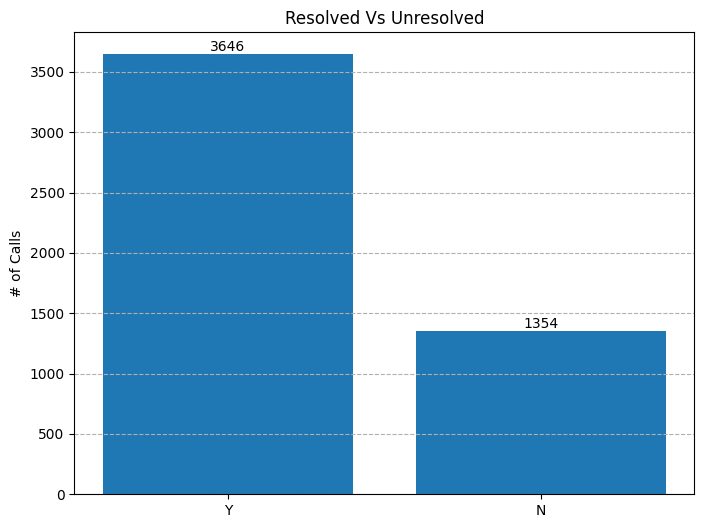

In [50]:
counts = df['resolved'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Resolved Vs Unresolved')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

When looking at the topics and there frequency there isn't a massive outlier. Streaming is the most frequent topic narrowly ahead of technical support. Next step is to see the breakdown of what's being resolved and what's not.

In [30]:
# Count the occurrences of each unique topic
topic_counts = df['topic'].value_counts()
topic_counts

topic
Streaming            1022
Technical Support    1019
Payment related      1007
Contract related      976
Admin Support         976
Name: count, dtype: int64

There doesn't appear to be any outliers in terms of topics or agents as well when it comes to unresolved issues. However, looking at the number of null values (946) in the data cleaning section there might be some insights once they are removed.

In [51]:
# Is there a certain 'topic' that is driving the number of unresolved issues?

# Filter rows where 'resolved' is 'N' (unresolved issues)
unresolved_df = df[df['resolved'] == 'N']

# Group by the 'topic' column and count unresolved issues
unresolved_counts = unresolved_df.groupby('topic').size()

# Sort the counts in descending order
unresolved_counts_sorted = unresolved_counts.sort_values(ascending=False)

# Display the result
unresolved_counts_sorted


topic
Technical Support    283
Payment related      278
Streaming            273
Contract related     267
Admin Support        253
dtype: int64


In [53]:
# Is there a certain 'agent' that is driving the number of unresolved issues?

# Group by the 'count' column and count unresolved issues
unresolved_counts_agents = unresolved_df.groupby('agent').size()

# Sort the counts in descending order
unresolved_counts_agents_sorted = unresolved_counts_agents.sort_values(ascending=False)

# Display the result
unresolved_counts_agents_sorted


agent
Diane      181
Jim        181
Martha     177
Becky      169
Greg       169
Dan        162
Stewart    158
Joe        157
dtype: int64

## Resolution Rate - Excluding Calls Not Answered
Here I am performing the same steps as above but with Null Values excluded to see how much things change. The biggest change as you can imagine is in the resolution rate going from 73% to 90%. There still isn't one agent or topic that is driving the 10% of unresolved calls so in the next section I look at the data related to unanswered calls as this is what's driving the majority of unresolved issues.

In [58]:
# Create a DF with null values excluded
clean_df = df.dropna()

In [68]:
# Calculate total issues
total_issues = clean_df['resolved'].count()

# Count resolved issues
resolved_issues = (clean_df['resolved'] == 'Y').sum()

# Calculate the percentage
percentage_resolved = (resolved_issues / total_issues) * 100

(f"Percentage of resolved issues: {percentage_resolved:.0f}%")

'Percentage of resolved issues: 90%'

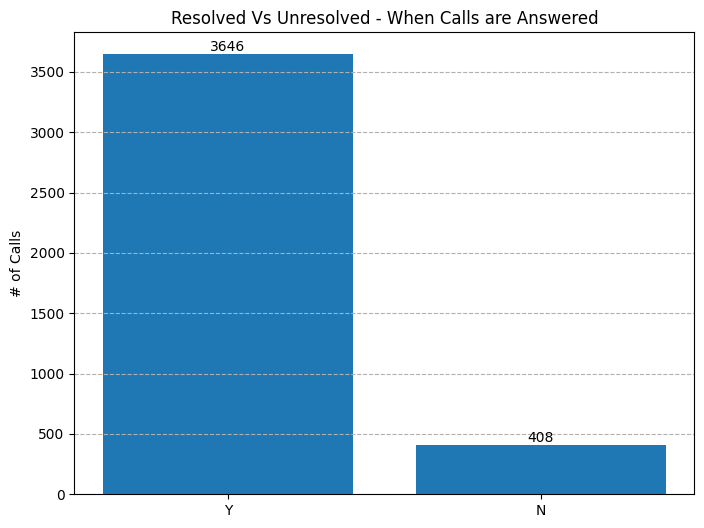

In [70]:
counts = clean_df['resolved'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Resolved Vs Unresolved - When Calls are Answered')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

In [75]:
# Filter rows where 'resolved' is 'N' (unresolved issues)
unresolved_clean_df = clean_df[clean_df['resolved'] == 'N']

# Group by the 'topic' column and count unresolved issues
unresolved_counts_clean = unresolved_clean_df.groupby('topic').size()

unresolved_counts_clean.sort_values(ascending=False)


topic
Streaming            98
Payment related      89
Contract related     80
Admin Support        72
Technical Support    69
dtype: int64

In [76]:
clean_count_agent = unresolved_clean_df.groupby('agent').size()

clean_count_agent.sort_values(ascending=False)

agent
Becky      55
Martha     53
Stewart    53
Dan        52
Jim        51
Diane      49
Joe        48
Greg       47
dtype: int64

## Unanswered Calls

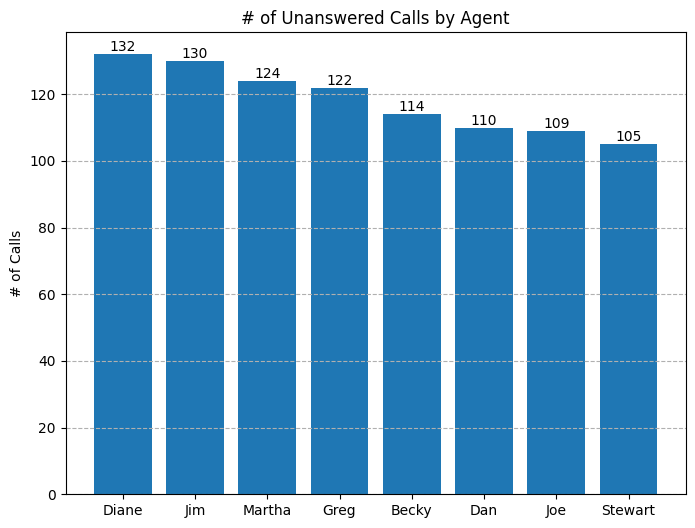

In [77]:
unanswered_calls_df = df[df["answered (y/n)"]=='N']

unanswered_counts = unanswered_calls_df['agent'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(unanswered_counts.index, unanswered_counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('# of Unanswered Calls by Agent')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()